In [1]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
import pyproj

import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

# check pytorch version
import torch    
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim    

from tqdm import tqdm

from pyproj import Proj, transform
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import torch

import time

from scipy.interpolate import griddata

import cdsapi
import xarray as xr
from urllib.request import urlopen

from urllib.request import urlretrieve

import pickle

import scipy.io as sio

%load_ext autoreload
%autoreload 2

from functions import *
from torch_model import *

## Read sea ice OBSERVATION data

In [171]:
import scipy.io as sio

filename = 'D:\\ISSM\\transient_y20_r000.mat'
rate = float(filename[-7:-4])*0.1
test = sio.loadmat('D:\\ISSM\\transient_y20_r040.mat')

In [154]:
x = test['S'][0][0][0]
print(x.shape)
y = test['S'][0][0][1]
print(y.shape)
elements = test['S'][0][0][2]-1
print(elements.shape)

smb = test['S'][0][0][3]
print(smb.shape)
vx = test['S'][0][0][4]
print(vx.shape)
vy = test['S'][0][0][5]
print(vy.shape)
vel = test['S'][0][0][6]
print(vel.shape)
H = test['S'][0][0][7]
print(H.shape)

n_year, n_sample = H.shape

(1112, 1)
(1112, 1)
(2085, 3)
(240, 1112)
(240, 1112)
(240, 1112)
(240, 1112)
(240, 1112)


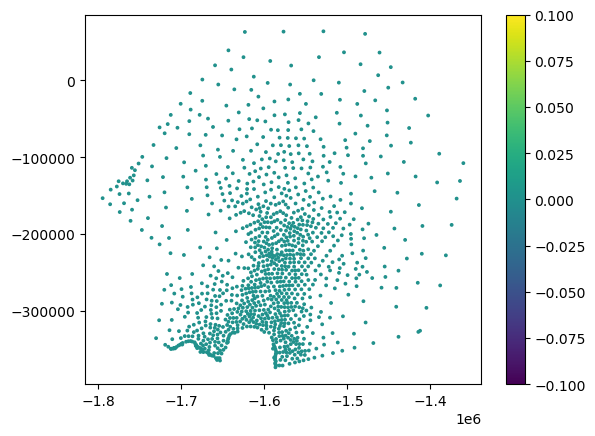

In [169]:
plt.scatter(x, y, c = smb[220]-smb[0], s= 3)
plt.colorbar()

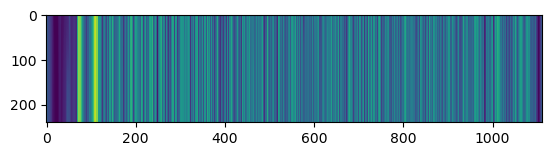

In [165]:
plt.imshow(H)

In [172]:
H.min(), H.max()

(0.9999999999999999, 3082.031143645382)

In [176]:
vy.min(), vy.max()

(-4672.572875290962, 280.0400805544056)

In [ ]:
def add_edge_to_graph(G, e1, e2, w):
    G.add_edge(e1, e2, weight=w)


G = nx.Graph()
points = [(1, 10), (8, 10), (10, 8), (7, 4), (3, 1)]  # (x,y) points
edges = [(0, 1, 10), (1, 2, 5), (2, 3, 25), (0, 3, 3), (3, 4, 8)]  # (v1,v2, weight)

for i in range(len(edges)):
    add_edge_to_graph(G, points[edges[i][0]], points[edges[i][1]], edges[i][2])

# you want your own layout
# pos = nx.spring_layout(G)
pos = {point: point for point in points}

# add axis
fig, ax = plt.subplots()
nx.draw(G, pos=pos, node_color='k', ax=ax)
nx.draw(G, pos=pos, node_size=1500, ax=ax)  # draw nodes and edges
nx.draw_networkx_labels(G, pos=pos)  # draw node labels/names
# draw edge weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
plt.axis("on")
ax.set_xlim(0, 11)
ax.set_ylim(0,11)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [49]:
p1, p2 = np.where(elements == 49)

In [50]:
p1

array([196, 967, 968], dtype=int64)

In [48]:
print(elements[196])
print(elements[967])
print(elements[968])

[ 49 287  48]
[929 287  49]
[ 50 929  49]


In [67]:
files = glob.glob('D:\\ISSM\\transient_y20_r*.mat')

train_list = []
val_list = []

for filename in tqdm(files[::2]):
    
    rate = float(filename[-7:-4])
    test = sio.loadmat(filename)
    
    xc = test['S'][0][0][0]
    yc = test['S'][0][0][1]
    elements = test['S'][0][0][2]-1

    smb = test['S'][0][0][3]
    vx = test['S'][0][0][4]
    vy = test['S'][0][0][5]
    vel = test['S'][0][0][6]
    H = test['S'][0][0][7]

    n_year, n_sample = H.shape

    for t in range(0, n_year):
        G = nx.Graph()
        for i in range(0, n_sample):        
            inputs = [(xc[i, 0]-xc.min())/(xc.max()-xc.min()), (yc[i, 0]-yc.min())/(yc.max()-yc.min()), rate*0.001, t/n_year]
            outputs = [smb[t,i], vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000]
            G.add_node(i, x = inputs, y = outputs)

            p1, p2 = np.where(elements == i)

            for p in p1:
                for k in elements[p]:
                    if k != i:
                        dist = ((xc[i]-xc[k])**2+(yc[i]-yc[k])**2)**0.5
                        G.add_edge(i, k, edge_weight=np.exp(-(dist/55000)))
        
        data = from_networkx(G)
        if rate % 100 == 0:
            val_list.append(data)
        else:
            if t % 4 == 0:
                val_list.append(data)
            else:
                train_list.append(data)
            
torch.save(train_list, f'Grid_graph_train_data.pt')
torch.save(val_list, f'Grid_graph_val_data.pt')

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [27:54<00:00, 93.05s/it]


In [164]:
b = torch.tensor(data.x, dtype=torch.float32)
edge_index = data.edge_index

e_st, e_end = edge_index[0, :], edge_index[1, :]
dists = torch.norm(b[e_st, :2] - b[e_end, :2], dim=1).reshape(-1, 1)

In [208]:
e_st, e_end = edge_index[0, :], edge_index[1, :]
dists = torch.norm(b[e_st, :2] - b[e_end, :2], dim=1).reshape(-1, 1)

# compute messages
tmp = torch.hstack([b[e_st], b[e_end], dists])
m_ij = f_e(tmp)

# predict edges
e_ij = f_inf(m_ij)

# average e_ij-weighted messages  
# m_i is num_nodes x hid_dim
# m_i = index_sum(b.shape[0], e_ij*m_ij, edge_index[0,:], True)

# agg_size = b.shape[0]
# source = e_ij*m_ij
# idx = edge_index[0,:]
# tmp = torch.zeros((agg_size, source.shape[1]))
# # tmp = tmp.cuda() if cuda else tmp
# m_i = res = torch.index_add(tmp, 0, idx, source)

In [209]:
tmp.shape

torch.Size([102272, 9])

In [192]:
b.shape

torch.Size([17792, 4])

In [189]:
in_dim = 4
hid_dim = 128

f_e = nn.Sequential(
    nn.Linear(in_dim*2+1, hid_dim), nn.SiLU(),
    nn.Linear(hid_dim, hid_dim), nn.SiLU())

# preducts "soft" edges based on messages 
f_inf = nn.Sequential( 
    nn.Linear(hid_dim, 1),
    nn.Sigmoid()) 

f_h = nn.Sequential(
    nn.Linear(in_dim+hid_dim, hid_dim), nn.SiLU(),
    nn.Linear(hid_dim, hid_dim))

In [103]:
val_list = torch.load(f'Grid_graph_val_data.pt')
train_list = torch.load(f'Grid_graph_train_data.pt')

In [228]:
class GCNet(torch.nn.Module):
    def __init__(self, ch_input, ch_output, hidden_channels = 128):
        super().__init__()
        # torch.manual_seed(1234567)
        self.activation = nn.Tanh()
        self.conv1 = GCNConv(ch_input, hidden_channels, improved=True)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, improved=True)
        
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin4 = torch.nn.Linear(hidden_channels, ch_output)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x, edge_index):
        x = self.activation(self.conv1(x, edge_index)); #self.conv1(x)
        x = self.activation(self.conv2(x, edge_index));
        x = self.dropout(self.activation(self.lin1(x)));
        x = self.dropout(self.activation(self.lin2(x)));
        x = self.dropout(self.activation(self.lin3(x)));
        x = self.lin4(x);
        
        return x

def index_sum(agg_size, source, idx, cuda):
    """
        source is N x hid_dim [float]
        idx    is N           [int]
        
        Sums the rows source[.] with the same idx[.];
    """
    tmp = torch.zeros((agg_size, source.shape[1]))
    # tmp = tmp.cuda() if cuda else tmp
    res = torch.index_add(tmp, 0, idx, source)
    return res

class EGCNet(torch.nn.Module):
    def __init__(self, ch_input, ch_output, hidden_channels = 128):
        super().__init__()
        # torch.manual_seed(1234567)
        self.activation = nn.Tanh()
        self.emb = nn.Linear(in_dim, hid_dim) 
        self.gnn = ConvEGNN(hid_dim, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, hidden_channels, improved=True)
        
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin4 = torch.nn.Linear(hidden_channels, ch_output)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x, edge_index):
        x.pos = x[:, :2]
        x.h = x
        x.h = self.emb(x.h)
        x = self.gnn(x, edge_index); #self.conv1(x)
        # x = self.activation(self.conv2(x, edge_index));
        x1 = self.dropout(self.activation(self.lin1(x.h)));
        x1 = self.dropout(self.activation(self.lin2(x1)));
        x1 = self.dropout(self.activation(self.lin3(x1)));
        x1 = self.lin4(x1);
        
        return x1
    
class ConvEGNN(nn.Module):
    def __init__(self, in_dim, hid_dim, cuda=True):
        super().__init__()
        self.hid_dim=hid_dim
        self.cuda = cuda
        
        # computes messages based on hidden representations -> [0, 1]
        self.f_e = nn.Sequential(
            nn.Linear(in_dim*2+1, hid_dim), nn.SiLU(),
            nn.Linear(hid_dim, hid_dim), nn.SiLU())
        
        # preducts "soft" edges based on messages 
        self.f_inf = nn.Sequential( 
            nn.Linear(hid_dim, 1),
            nn.Sigmoid())
        
        # updates hidden representations -> [0, 1]
        self.f_h = nn.Sequential(
            nn.Linear(in_dim+hid_dim, hid_dim), nn.SiLU(),
            nn.Linear(hid_dim, hid_dim))
    
    def forward(self, b, edge_index):
        e_st, e_end = edge_index[0, :], edge_index[1, :]
        dists = torch.norm(b.pos[e_st] - b.pos[e_end], dim=1).reshape(-1, 1)
        
        # compute messages
        tmp = torch.hstack([b.h[e_st], b.h[e_end], dists])
        m_ij = self.f_e(tmp)
        
        # predict edges
        e_ij = self.f_inf(m_ij)
        
        # average e_ij-weighted messages  
        # m_i is num_nodes x hid_dim
        m_i = index_sum(b.shape[0], e_ij*m_ij, edge_index[0,:], self.cuda)
        
        # update hidden representations
        b.h += self.f_h(torch.hstack([b.h, m_i]))

        return b
    
class NetEGNN(nn.Module):
    def __init__(self, in_dim=15, hid_dim=128, out_dim=1, n_layers=7, cuda=True):
        super().__init__()
        self.hid_dim=hid_dim
        
        self.emb = nn.Linear(in_dim, hid_dim) 

        self.gnn = [ConvEGNN(hid_dim, hid_dim, cuda=cuda) for _ in range(n_layers)]
        self.gnn = nn.Sequential(*self.gnn)
        
        self.pre_mlp = nn.Sequential(
            nn.Linear(hid_dim, hid_dim), nn.SiLU(),
            nn.Linear(hid_dim, hid_dim))
        
        self.post_mlp = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(hid_dim, hid_dim), nn.SiLU(),
            nn.Linear(hid_dim, out_dim))

        if cuda: self.cuda()
        self.cuda = cuda
    
    def forward(self, b):
        b.h = self.emb(b.h)
        
        b = self.gnn(b)
        h_nodes = self.pre_mlp(b.h)
        
        # h_graph is num_graphs x hid_dim
        h_graph = index_sum(b.nG, h_nodes, b.batch, self.cuda) 
        
        out = self.post_mlp(h_graph)
        return out

In [231]:
### PREDICT ONLY SEA ICE U & V
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

##########################################################################################

data_path = "D:\\PINN\\data\\"

year = 2019
n_epochs = 100
batch_size = 16  # size of each batch
lr = 0.01

loader = DataLoader(train_list, batch_size=batch_size)
val_loader = DataLoader(val_list, batch_size=batch_size)

print("######## TRAINING/VALIDATION DATA IS PREPARED ########")

# Graph convolutional network
net = GCNet(4, 5)
# Equivariant Graph convolutional network
# net = EGCNet(4, 5)

torch.cuda.empty_cache()
device = torch.device('cpu') #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# net = nn.DataParallel(net, device_ids=[0])

net.to(device)

##### PHYSICS OR NOT #####
phy = "nophy"
##########################

if device == "cpu":
    device_name = "cpu"
else:
    device_name = "gpu"

model_name = f"torch_gcn_lr{lr}_wo{year}_{phy}_{device_name}"

if phy == "phy":
    loss_fn = physics_loss() # nn.L1Loss() #nn.CrossEntropyLoss()
elif phy == "nophy":
    loss_fn = nn.MSELoss() #custom_loss() # nn.L1Loss() #nn.CrossEntropyLoss()
    
optimizer = optim.Adam(net.parameters(), lr=lr)

history = {'loss': [], 'val_loss': [], 'time': []}

total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

## Train model #############################################################

t0 = time.time()

for n in range(0, n_epochs):
    net.train()    
    train_loss = 0.0
    val_loss = 0.0

    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        y_pred = net(torch.tensor(data.x, dtype=torch.float32).to(device), data.edge_index.to(device))  # Perform a single forward pass.
        y_true = torch.tensor(data.y, dtype=torch.float32)
        loss = loss_fn(y_pred.to(device), y_true.to(device))  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients. 
        train_loss += loss.item()

    net.eval()

    for val_data in val_loader:
        y_pred = net(torch.tensor(val_data.x, dtype=torch.float32).to(device), val_data.edge_index.to(device))  # Perform a single forward pass.
        y_true = torch.tensor(val_data.y, dtype = torch.float32)
        val_loss += loss_fn(y_pred.to(device), y_true.to(device)).item()  # Compute the loss solely based on the training nodes.

    history['loss'].append(train_loss/len(loader))
    history['val_loss'].append(val_loss/len(val_loader))
    history['time'].append(time.time()-t0)
    
    if n % 2== 0:
        print(n, "Epoch {0} - train: {1:.3f}, val: {2:.3f}".format(str(n).zfill(3), train_loss, val_loss))

torch.save(net.state_dict(), f'model/{model_name}.pth')

with open(f'model/history_{model_name}.pkl', 'wb') as file:
    pickle.dump(history, file)

######## TRAINING/VALIDATION DATA IS PREPARED ########
cpu
Number of parameters: 67333
0 Epoch 000 - train: 4.884, val: 3.100
2 Epoch 002 - train: 3.748, val: 2.621
4 Epoch 004 - train: 3.366, val: 2.401



KeyboardInterrupt



In [250]:
net = EGCNet(4, 5)

total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 149894


In [237]:
net = GCNet(4, 5)
net.load_state_dict(torch.load(f'model/{model_name}.pth'))
net.eval()

GCNet(
  (activation): Tanh()
  (conv1): GCNConv(4, 128)
  (conv2): GCNConv(128, 128)
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=128, bias=True)
  (lin4): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Text(0, 0.5, 'Loss')

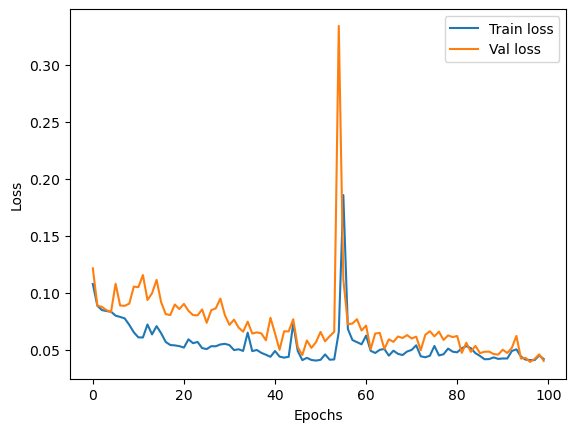

In [81]:
plt.plot(history['loss'], label = "Train loss")
plt.plot(history['val_loss'], label = "Val loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.yscale('log')

In [98]:
val_list

torch.Size([1112, 4])

In [238]:
scaling = [1, 5000, 5000, 5000, 4000]
y_pred = np.zeros([len(val_list), 1112, 5])
y_true = np.zeros([len(val_list), 1112, 5])
count = 0
for k in tqdm(range(0, len(val_list))):
    data = val_list[k]
    prd = net(data.x.to(torch.float).to(device), data.edge_index.to(device)).to('cpu').detach().numpy()
    tru = data.y.to('cpu').detach().numpy()
    for i in range(0, prd.shape[1]):
        prd[:, i] = prd[:, i]*scaling[i]
        tru[:, i] = tru[:, i]*scaling[i]
    y_pred[k] = prd
    y_true[k] = tru
    count += 1

100%|████████████████████████████████████████████████████████████████████████| 1800/1800 [00:14<00:00, 126.73it/s]


In [240]:
xc = data.x[:,0]
yc = data.x[:,1]

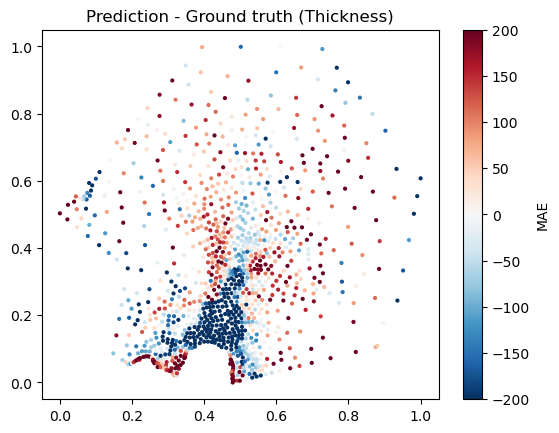

In [239]:
ind = 4
c = 4
err = np.mean((y_pred - y_true), axis=0)
plt.title(f"Prediction - Ground truth ({channels[c]})")
plt.scatter(xc, yc, c = err[:, c], s = 4, cmap = "RdBu_r", vmin = -200, vmax = 200)
plt.colorbar(label = "MAE")

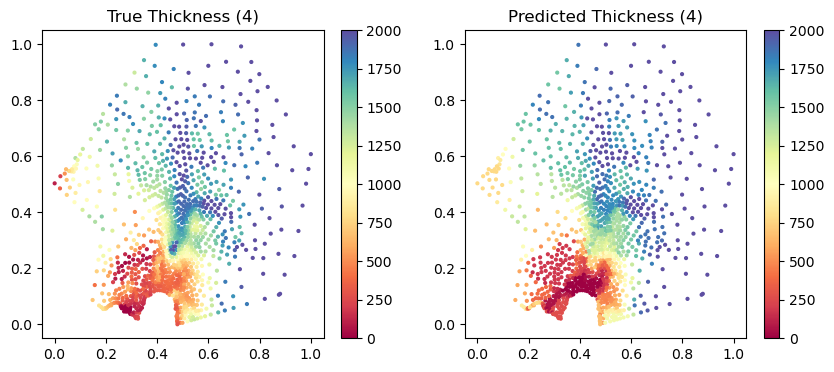

In [249]:
ind = 4
c = 4
err = np.mean(abs(y_pred - y_true), axis=0)
channels = ["SMB", "U velocity", "V velocity", "Velocity", "Thickness"]
vmax = [1, 4000, 4000, 4000, 2000]
vmin = [0, -4000, -4000, 0, 0]

fig, ax = plt.subplots(1,2, figsize = (10,4))
c1 = ax[0].scatter(xc, yc, c = y_true[ind, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[0].set_title(f"True {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[0])
c2 = ax[1].scatter(xc, yc, c = y_pred[ind, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[1].set_title(f"Predicted {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[1])

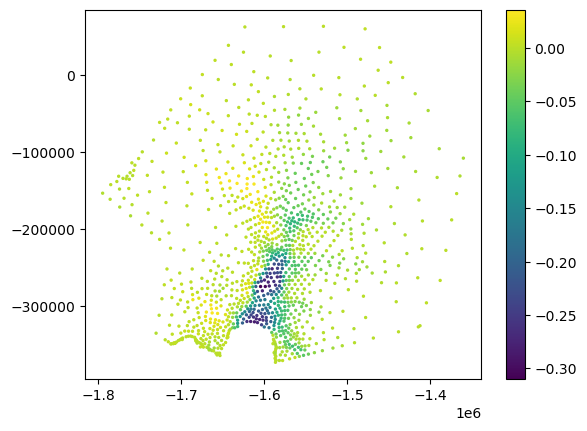

In [57]:
plt.scatter(xc, yc, c = vx[0]/5000, s = 2)
plt.colorbar()

205964106.30591267
205776418.05709606
205591376.5088661
205418323.7494367
205256813.25122318


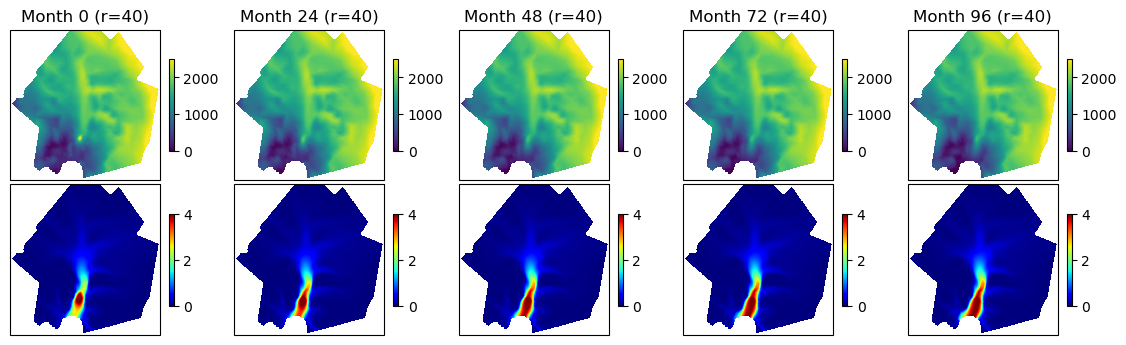

In [111]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r40.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol40 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel40 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=40)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

205968118.00278923
205910434.94427702
205842919.99588054
205773103.6475761
205704447.55447897


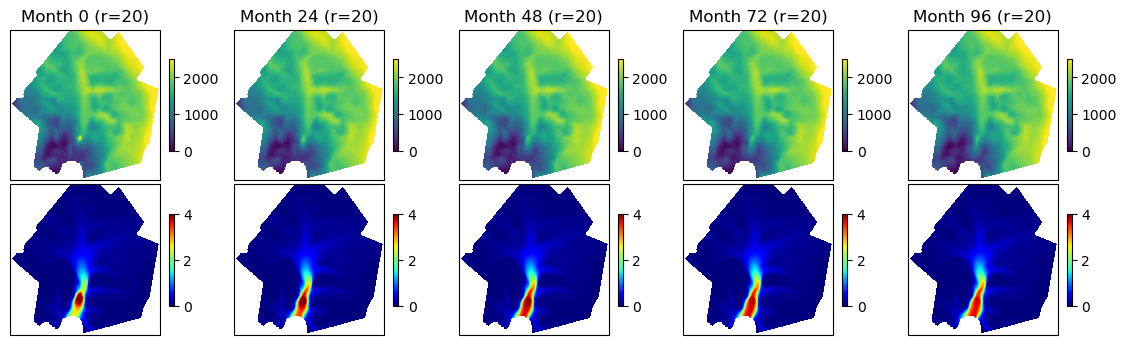

In [110]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r20.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol20 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel20 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=20)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

205970126.9921308
205978459.7669149
205974605.06885847
205963737.60910466
205945981.8779817


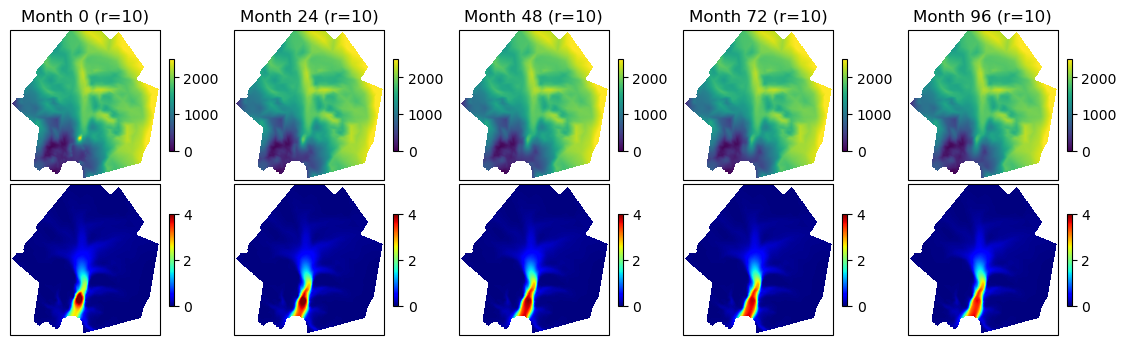

In [122]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r10.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol10 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel10 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=10)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

205971131.48680156
206012976.71163708
206041501.56193674
206060713.93202695
206071883.7007757


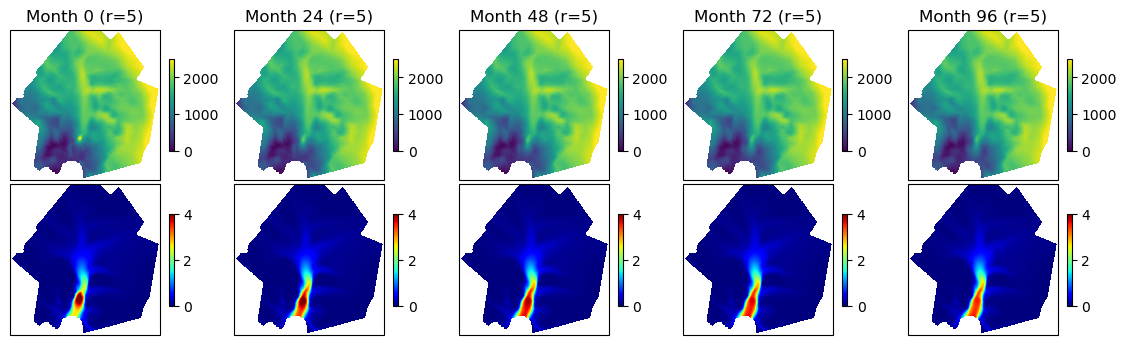

In [109]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r5.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol05 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel05 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=5)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

Text(0, 0.5, 'Total ice volume ($km^3$)')

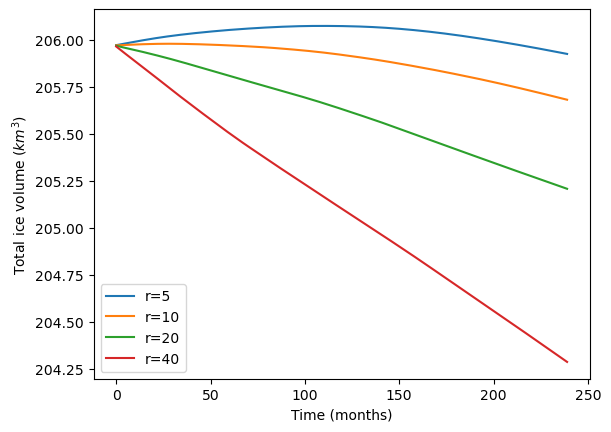

In [120]:
plt.plot(ice_vol05/1000000, label = "r=5")
plt.plot(ice_vol10/1000000, label = "r=10")
plt.plot(ice_vol20/1000000, label = "r=20")
plt.plot(ice_vol40/1000000, label = "r=40")
plt.legend()
plt.xlabel("Time (months)")
plt.ylabel("Total ice volume ($km^3$)")

Text(0, 0.5, 'Mean ice velocity (m/year)')

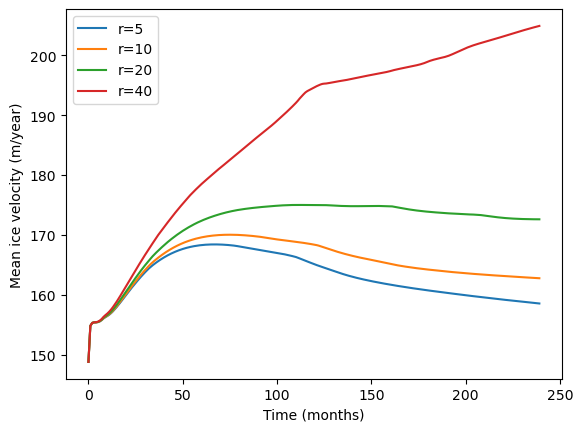

In [121]:
plt.plot(ice_vel05, label = "r=5")
plt.plot(ice_vel10, label = "r=10")
plt.plot(ice_vel20, label = "r=20")
plt.plot(ice_vel40, label = "r=40")
plt.legend()
plt.xlabel("Time (months)")
plt.ylabel("Mean ice velocity (m/year)")

In [4]:
import scipy.io as sio

filename = "D:\\ISSM\\transient_y20_r0.0.mat"
mat = sio.loadmat(filename)

In [6]:
mat['S'][0]

array([(array([[[nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               ...,
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan]],

              [[nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               ...,
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan]],

              [[nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               ...,
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan]]

In [ ]:
mat73.loadmat(full_path)